Number of images loaded: 2201


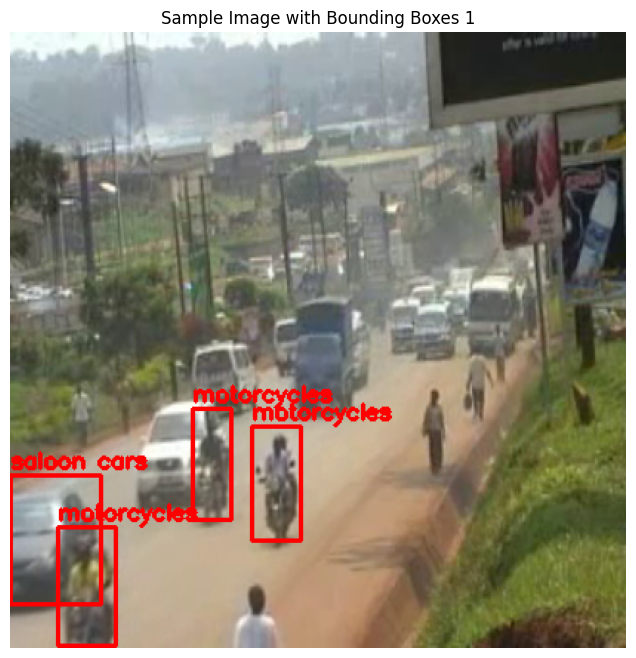

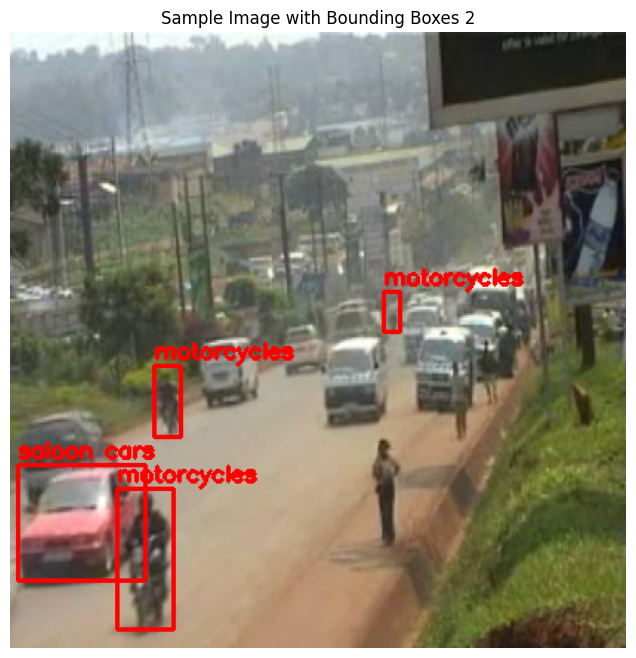

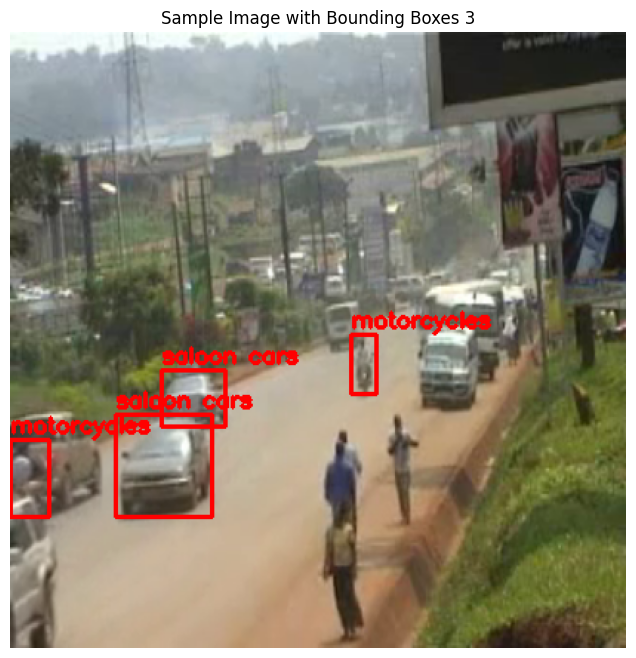

Splitting dataset into training and validation sets...
Dataset splitting completed.
YOLO formatted data saved in yolo_dataset/train
YOLO formatted data saved in yolo_dataset/val


In [1]:
import os
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(annotation_dir, image_dir, image_size=(416, 416)):
    data = []
    for filename in os.listdir(annotation_dir):
        if filename.endswith('.xml'):
            annotation_path = os.path.join(annotation_dir, filename)
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            image_name = root.find('filename').text
            image_path = os.path.join(image_dir, image_name)
            if os.path.exists(image_path):
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                original_size = image.shape[:2]  # Original size (height, width)
                image = cv2.resize(image, image_size)
                
                objects = root.findall('object')
                bboxes = []
                labels = []
                for obj in objects:
                    class_name = obj.find('name').text
                    bbox = obj.find('bndbox')
                    xmin = int(float(bbox.find('xmin').text))
                    ymin = int(float(bbox.find('ymin').text))
                    xmax = int(float(bbox.find('xmax').text))
                    ymax = int(float(bbox.find('ymax').text))
                    
                    # Normalize bounding box coordinates
                    norm_bbox = [
                        xmin / original_size[1],
                        ymin / original_size[0],
                        xmax / original_size[1],
                        ymax / original_size[0]
                    ]
                    
                    bboxes.append(norm_bbox)
                    labels.append(class_name)
                
                data.append({
                    'image': image,
                    'bboxes': bboxes,
                    'labels': labels
                })
    return data

def display_sample_images_with_bounding_boxes(data, num_samples=3):
    print("Number of images loaded:", len(data))
    for i in range(min(num_samples, len(data))):
        sample = data[i]
        image = sample['image'].copy()
        
        bboxes = sample['bboxes']
        labels = sample['labels']
        for bbox, label in zip(bboxes, labels):
            xmin, ymin, xmax, ymax = (np.array(bbox) * np.array([image.shape[1], image.shape[0], image.shape[1], image.shape[0]])).astype(int)
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)  # Draw red bounding box
            cv2.putText(image, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title(f"Sample Image with Bounding Boxes {i+1}")
        plt.axis('off')
        plt.show()

def split_dataset(data, test_size=0.2):
    print("Splitting dataset into training and validation sets...")
    train_data, val_data = train_test_split(data, test_size=test_size, random_state=42)
    print("Dataset splitting completed.")
    return train_data, val_data

def convert_to_yolo_format(data, output_dir, class_to_index, image_size=(416, 416)):
    image_dir = os.path.join(output_dir, 'images')
    labels_dir = os.path.join(output_dir, 'labels')
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    
    for i, sample in enumerate(data):
        image = sample['image']
        bboxes = sample['bboxes']
        labels = sample['labels']
        
        # Save image
        image_path = os.path.join(image_dir, f'{i:06d}.jpg')
        cv2.imwrite(image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        
        # Save labels
        label_path = os.path.join(labels_dir, f'{i:06d}.txt')
        with open(label_path, 'w') as f:
            for bbox, label in zip(bboxes, labels):
                if label not in class_to_index:
                    print(f"Warning: '{label}' not found in class_to_index. Skipping.")
                    continue
                class_index = class_to_index[label]
                x_center = (bbox[0] + bbox[2]) / 2
                y_center = (bbox[1] + bbox[3]) / 2
                width = bbox[2] - bbox[0]
                height = bbox[3] - bbox[1]
                f.write(f'{class_index} {x_center} {y_center} {width} {height}\n')
    
    print(f"YOLO formatted data saved in {output_dir}")

# Define the directories for annotations and images
annotation_dir = 'dataset/Annotations'
image_dir = 'dataset/JPEGImages'
output_dir = 'yolo_dataset'

# Load data
data = load_data(annotation_dir, image_dir)

# Display sample images with bounding boxes
display_sample_images_with_bounding_boxes(data, num_samples=3)

# Split dataset
train_data, val_data = split_dataset(data)

# Define class to index mapping
class_to_index = {
    'motorcycles': 0,
    'saloon cars': 1,
    # Add other classes as needed
}

# Convert to YOLO format and save
convert_to_yolo_format(train_data, os.path.join(output_dir, 'train'), class_to_index)
convert_to_yolo_format(val_data, os.path.join(output_dir, 'val'), class_to_index)


In [5]:
import os
import xml.etree.ElementTree as ET

def load_true_labels(annotation_dir):
    true_labels = []
    for filename in os.listdir(annotation_dir):
        if filename.endswith('.xml'):
            annotation_path = os.path.join(annotation_dir, filename)
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                true_labels.append(class_name)
    return true_labels

# Define the directory for annotations
annotation_dir = 'dataset/Annotations'

# Load true labels
y_true = load_true_labels(annotation_dir)
print("True labels loaded:", y_true[:10])  # Display first 10 true labels as a sample


True labels loaded: ['motorcycles', 'motorcycles', 'motorcycles', 'saloon cars', 'motorcycles', 'motorcycles', 'motorcycles', 'saloon cars', 'saloon cars', 'saloon cars']


In [9]:
import os

# List the contents of the current working directory
print("Contents of the current directory:", os.listdir('.'))

# List the contents of the 'runs' directory, if it exists
if os.path.exists('runs'):
    print("Contents of the 'runs' directory:", os.listdir('runs'))
else:
    print("'runs' directory does not exist.")


Contents of the current directory: ['Yolo_Model.ipynb', 'yolov5', 'Yolo folder', 'Computer Vision.ipynb', 'dataset', 'yolo_dataset', 'Final.ipynb', 'dataset.zip', '.venv', '.idea', 'New_trial.ipynb', 'obj_train_data.txt']
'runs' directory does not exist.


In [2]:
import os

# Define the path to the training directory
runs_train_directory = 'yolov5/runs/train/custom_yolov5s_results/weights/'

# Check if 'best.pt' file exists
best_pt_path = os.path.join(runs_train_directory, 'best.pt')
if os.path.exists(best_pt_path):
    print(f"Found best.pt at {best_pt_path}")
else:
    print("best.pt file not found.")


Found best.pt at yolov5/runs/train/custom_yolov5s_results/weights/best.pt


In [8]:
import time

# Make a request
# Wait for a few seconds before making the next request
time.sleep(5)  # Wait for 5 seconds
# Make the next request


In [9]:
import asyncio

async def fetch_data(url):
    # Make request here
    pass

async def main():
    urls = [...]  # List of URLs to request
    tasks = [fetch_data(url) for url in urls]
    await asyncio.gather(*tasks)

asyncio.run(main())


RuntimeError: asyncio.run() cannot be called from a running event loop

In [8]:
import os

annotation_dir = 'dataset/Annotations'
test_images_dir = '/home/gideon/Documents/MSCS -/Year One- sem-Two/Computer Vision/Exam Project/Computer Vision  Exam Project/yolo_dataset/val/images'

# Function to map image to annotation
def map_image_to_annotation(image_path, annotation_dir):
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    expected_annotation_file = f"frame_{base_name}.xml"
    annotation_path = os.path.join(annotation_dir, expected_annotation_file)
    if os.path.exists(annotation_path):
        return annotation_path
    return None

# Check mapping for a few images
image_files = os.listdir(test_images_dir)
print("Image files:", image_files[:10])  # Print first 10 image files to check

for img_file in image_files[:5]:  # Check first 5 image files
    img_path = os.path.join(test_images_dir, img_file)
    annotation_path = map_image_to_annotation(img_path, annotation_dir)
    if annotation_path:
        print(f"Annotation path for {img_file}: {annotation_path}")
    else:
        print(f"No annotation path found for {img_file}")

# Now, extract true labels from annotations using the new mapping function
def extract_true_labels(annotation_dir, image_paths):
    true_labels = []
    for image_path in image_paths:
        annotation_path = map_image_to_annotation(image_path, annotation_dir)
        if annotation_path:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            objects = root.findall('object')
            for obj in objects:
                true_labels.append(obj.find('name').text)
        else:
            print(f"Annotation file not found for image: {os.path.basename(image_path)}")
    if len(true_labels) == 0:
        raise ValueError("No annotations found. Check your annotation directory and files.")
    return true_labels

# Get predictions
results, image_paths = get_predictions(model_path, test_images_dir)

# Extract true labels from annotations
true_labels = extract_true_labels(annotation_dir, image_paths)

# Extract predicted labels from model results
predicted_labels = extract_labels_and_predictions(results)

# Ensure true_labels and predicted_labels have the same length
min_length = min(len(true_labels), len(predicted_labels))
true_labels = true_labels[:min_length]
predicted_labels = predicted_labels[:min_length]

# Evaluate the model
cm, auc, precision, recall, f1 = evaluate_model(true_labels, predicted_labels, class_names)

# Print the evaluation metrics
print(f"Confusion Matrix:\n{cm}")
if auc is not None:
    print(f"AUC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names)


Image files: ['000145.jpg', '000410.jpg', '000278.jpg', '000071.jpg', '000356.jpg', '000093.jpg', '000194.jpg', '000237.jpg', '000423.jpg', '000368.jpg']
Annotation path for 000145.jpg: dataset/Annotations/frame_000145.xml
Annotation path for 000410.jpg: dataset/Annotations/frame_000410.xml
Annotation path for 000278.jpg: dataset/Annotations/frame_000278.xml
Annotation path for 000071.jpg: dataset/Annotations/frame_000071.xml
Annotation path for 000356.jpg: dataset/Annotations/frame_000356.xml


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/gideon/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Confusion Matrix:
[[ 0  0  0]
 [ 0  1  2]
 [ 0  6 14]]
Precision: 0.7795
Recall: 0.6522
F1 Score: 0.7024


In [3]:
import torch
import numpy as np
import os
import xml.etree.ElementTree as ET
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

def get_predictions(model_path, image_paths, img_size=416):
    # Load the YOLOv5 model from the local repository
    model = torch.hub.load('yolov5', 'custom', path=model_path, source='local')
    results = model(image_paths, size=img_size)
    return results

def map_image_to_annotation(image_path, annotation_dir):
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    expected_annotation_file = f"frame_{base_name}.xml"
    annotation_path = os.path.join(annotation_dir, expected_annotation_file)
    if os.path.exists(annotation_path):
        return annotation_path
    return None

def extract_true_labels(annotation_dir, image_paths):
    true_labels = []
    for image_path in image_paths:
        annotation_path = map_image_to_annotation(image_path, annotation_dir)
        if annotation_path:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            objects = root.findall('object')
            for obj in objects:
                true_labels.append(obj.find('name').text)
        else:
            print(f"Annotation file not found for image: {os.path.basename(image_path)}")
    return true_labels

def extract_labels_and_predictions(results):
    predicted_labels = []
    for result in results.pandas().xyxy:
        for _, row in result.iterrows():
            pred_label = row['name']
            predicted_labels.append(pred_label)
    return predicted_labels

def evaluate_model(true_labels, predicted_labels, class_names):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)
    
    # Compute AUC, precision, recall, and F1 score
    try:
        auc = roc_auc_score(true_labels, predicted_labels, multi_class='ovr', labels=class_names)
    except ValueError:
        auc = None
        print("ROC AUC score could not be computed.")
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted', labels=class_names)
    
    return cm, auc, precision, recall, f1

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_in_parts(model_path, test_images_dir, annotation_dir, class_names, batch_size=10):
    all_true_labels = []
    all_predicted_labels = []
    image_paths = [os.path.join(test_images_dir, img) for img in os.listdir(test_images_dir) if img.endswith(('jpg', 'jpeg', 'png'))]
    total_images = len(image_paths)
    
    for i in range(0, total_images, batch_size):
        batch_image_paths = image_paths[i:i + batch_size]
        print(f"Evaluating batch {i // batch_size + 1} of {total_images // batch_size + 1}")
        
        # Get predictions
        results = get_predictions(model_path, batch_image_paths)
        
        # Extract true labels from annotations
        true_labels = extract_true_labels(annotation_dir, batch_image_paths)
        
        # Extract predicted labels from model results
        predicted_labels = extract_labels_and_predictions(results)
        
        # Accumulate the labels
        all_true_labels.extend(true_labels)
        all_predicted_labels.extend(predicted_labels)

        # Print progress after each batch
        print(f"Batch {i // batch_size + 1} processed. True labels: {len(true_labels)}, Predicted labels: {len(predicted_labels)}")

    # Ensure all_true_labels and all_predicted_labels have the same length
    min_length = min(len(all_true_labels), len(all_predicted_labels))
    all_true_labels = all_true_labels[:min_length]
    all_predicted_labels = all_predicted_labels[:min_length]
    
    # Evaluate the model
    cm, auc, precision, recall, f1 = evaluate_model(all_true_labels, all_predicted_labels, class_names)
    
    # Print the evaluation metrics
    print(f"Confusion Matrix:\n{cm}")
    if auc is not None:
        print(f"AUC: {auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Plot the confusion matrix
    plot_confusion_matrix(cm, class_names)

# Define paths
model_path = 'yolov5/runs/train/custom_yolov5s_results/weights/best.pt'
test_images_dir = '/home/gideon/Documents/MSCS -/Year One- sem-Two/Computer Vision/Exam Project/Computer Vision  Exam Project/yolo_dataset/val/images'
annotation_dir = 'dataset/Annotations'  # Set this to your annotation directory

# Define class names
class_names = ['background', 'saloon cars', 'motorcycles']

# Evaluate the model in parts
evaluate_in_parts(model_path, test_images_dir, annotation_dir, class_names, batch_size=10)


YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Evaluating batch 1 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 1 processed. True labels: 62, Predicted labels: 37
Evaluating batch 2 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 2 processed. True labels: 52, Predicted labels: 36
Evaluating batch 3 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 3 processed. True labels: 57, Predicted labels: 24
Evaluating batch 4 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 4 processed. True labels: 43, Predicted labels: 20
Evaluating batch 5 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 5 processed. True labels: 63, Predicted labels: 27
Evaluating batch 6 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 6 processed. True labels: 58, Predicted labels: 23
Evaluating batch 7 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 7 processed. True labels: 50, Predicted labels: 57
Evaluating batch 8 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 8 processed. True labels: 71, Predicted labels: 19
Evaluating batch 9 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 9 processed. True labels: 63, Predicted labels: 47
Evaluating batch 10 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 10 processed. True labels: 59, Predicted labels: 28
Evaluating batch 11 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 11 processed. True labels: 60, Predicted labels: 37
Evaluating batch 12 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 12 processed. True labels: 76, Predicted labels: 33
Evaluating batch 13 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 13 processed. True labels: 54, Predicted labels: 51
Evaluating batch 14 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 14 processed. True labels: 57, Predicted labels: 34
Evaluating batch 15 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 15 processed. True labels: 67, Predicted labels: 29
Evaluating batch 16 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 16 processed. True labels: 59, Predicted labels: 27
Evaluating batch 17 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 17 processed. True labels: 70, Predicted labels: 23
Evaluating batch 18 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 18 processed. True labels: 84, Predicted labels: 42
Evaluating batch 19 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 19 processed. True labels: 61, Predicted labels: 42
Evaluating batch 20 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 20 processed. True labels: 69, Predicted labels: 31
Evaluating batch 21 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 21 processed. True labels: 56, Predicted labels: 41
Evaluating batch 22 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 22 processed. True labels: 85, Predicted labels: 28
Evaluating batch 23 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 23 processed. True labels: 48, Predicted labels: 30
Evaluating batch 24 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 24 processed. True labels: 80, Predicted labels: 33
Evaluating batch 25 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 25 processed. True labels: 54, Predicted labels: 45
Evaluating batch 26 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 26 processed. True labels: 75, Predicted labels: 37
Evaluating batch 27 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 27 processed. True labels: 54, Predicted labels: 22
Evaluating batch 28 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 28 processed. True labels: 59, Predicted labels: 21
Evaluating batch 29 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 29 processed. True labels: 66, Predicted labels: 39
Evaluating batch 30 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 30 processed. True labels: 63, Predicted labels: 44
Evaluating batch 31 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 31 processed. True labels: 84, Predicted labels: 27
Evaluating batch 32 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 32 processed. True labels: 66, Predicted labels: 57
Evaluating batch 33 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 33 processed. True labels: 54, Predicted labels: 54
Evaluating batch 34 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 34 processed. True labels: 56, Predicted labels: 40
Evaluating batch 35 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 35 processed. True labels: 81, Predicted labels: 28
Evaluating batch 36 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 36 processed. True labels: 82, Predicted labels: 42
Evaluating batch 37 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 37 processed. True labels: 62, Predicted labels: 43
Evaluating batch 38 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 38 processed. True labels: 86, Predicted labels: 37
Evaluating batch 39 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 39 processed. True labels: 65, Predicted labels: 35
Evaluating batch 40 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 40 processed. True labels: 72, Predicted labels: 36
Evaluating batch 41 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 41 processed. True labels: 58, Predicted labels: 31
Evaluating batch 42 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 42 processed. True labels: 60, Predicted labels: 27
Evaluating batch 43 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 43 processed. True labels: 71, Predicted labels: 40
Evaluating batch 44 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 2024-6-8 Python-3.9.19 torch-2.3.0+cu121 CPU

Fusing layers... 


Batch 44 processed. True labels: 69, Predicted labels: 30
Evaluating batch 45 of 45


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Batch 45 processed. True labels: 12, Predicted labels: 0
ROC AUC score could not be computed.
Confusion Matrix:
[[  0   0   0]
 [  0  61 126]
 [  0 399 948]]
Precision: 0.7912
Recall: 0.6578
F1 Score: 0.7107


In [8]:
import torch
import numpy as np
import os
import xml.etree.ElementTree as ET
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def get_predictions(model_path, image_paths, img_size=416):
    # Load the YOLOv5 model from the local repository
    model = torch.hub.load('yolov5', 'custom', path=model_path, source='local')
    results = model(image_paths, size=img_size)
    return results

def map_image_to_annotation(image_path, annotation_dir):
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    expected_annotation_file = f"frame_{base_name}.xml"
    annotation_path = os.path.join(annotation_dir, expected_annotation_file)
    if os.path.exists(annotation_path):
        return annotation_path
    return None

def extract_true_labels(annotation_dir, image_paths):
    true_labels = []
    for image_path in image_paths:
        annotation_path = map_image_to_annotation(image_path, annotation_dir)
        if annotation_path:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            objects = root.findall('object')
            for obj in objects:
                true_labels.append(obj.find('name').text)
        else:
            print(f"Annotation file not found for image: {os.path.basename(image_path)}")
    return true_labels

def extract_labels_and_predictions(results):
    predicted_labels = []
    for result in results.pandas().xyxy:
        for _, row in result.iterrows():
            pred_label = row['name']
            predicted_labels.append(pred_label)
    return predicted_labels

def evaluate_model(true_labels, predicted_labels, class_names):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)
    
    # Compute AUC, precision, recall, and F1 score
    try:
        auc = roc_auc_score(true_labels, predicted_labels, multi_class='ovr', labels=class_names)
    except ValueError:
        auc = None
        print("ROC AUC score could not be computed.")
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted', labels=class_names)
    
    # Plot ROC curve
    plot_roc_curve(model, X_test, y_test, labels=class_names)
    plt.title('ROC Curve')
    plt.show()
    
    return cm, auc, precision, recall, f1

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_in_parts(model_path, test_images_dir, annotation_dir, class_names, batch_size=10):
    all_true_labels = []
    all_predicted_labels = []
    image_paths = [os.path.join(test_images_dir, img) for img in os.listdir(test_images_dir) if img.endswith(('jpg', 'jpeg', 'png'))]
    total_images = len(image_paths)
    
    for i in range(0, total_images, batch_size):
        batch_image_paths = image_paths[i:i + batch_size]
        print(f"Evaluating batch {i // batch_size + 1} of {total_images // batch_size + 1}")
        
        # Get predictions
        results = get_predictions(model_path, batch_image_paths)
        
        # Extract true labels from annotations
        true_labels = extract_true_labels(annotation_dir, batch_image_paths)
        
        # Extract predicted labels from model results
        predicted_labels = extract_labels_and_predictions(results)
        
        # Accumulate the labels
        all_true_labels.extend(true_labels)
        all_predicted_labels.extend(predicted_labels)

        # Print progress after each batch
        print(f"Batch {i // batch_size + 1} processed. True labels: {len(true_labels)}, Predicted labels: {len(predicted_labels)}")

    # Ensure all_true_labels and all_predicted_labels have the same length
    min_length = min(len(all_true_labels), len(all_predicted_labels))
    all_true_labels = all_true_labels[:min_length]
    all_predicted_labels = all_predicted_labels[:min_length]
    
    # Evaluate the model
    cm, auc, precision, recall, f1 = evaluate_model(all_true_labels, all_predicted_labels, class_names)
    
    # Print the evaluation metrics
    print(f"Confusion Matrix:\n{cm}")
    if auc is not None:
        print(f"AUC: {auc:.4f}")
    print(f"Precision: {precision:.4f}")


ImportError: cannot import name 'plot_roc_curve' from 'sklearn.metrics' (/home/gideon/Documents/MSCS -/Year One- sem-Two/Computer Vision/Exam Project/Computer Vision  Exam Project/.venv/lib/python3.9/site-packages/sklearn/metrics/__init__.py)